In [2]:
# /content/drive/MyDrive/Projects/image_localization/training_images

In [2]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from xml.dom import minidom
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from skimage import io

In [4]:
obj = minidom.parse('training_images/cucumber_1.xml')
width = obj.getElementsByTagName('width')
int(width[0].firstChild.nodeValue)

227

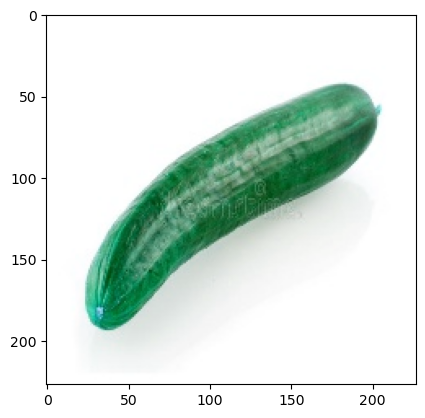

In [5]:
img = cv2.imread('training_images/cucumber_1.jpg',cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [6]:
def get_value(obj,name) :
    a = int(obj.getElementsByTagName(name)[0].firstChild.nodeValue)
    return a

In [7]:
xmin = get_value(obj,'xmin')
ymin = get_value(obj,'ymin')
xmax = get_value(obj,'xmax')
ymax = get_value(obj,'ymax')
width = get_value(obj,'width')
height = get_value(obj,'height')

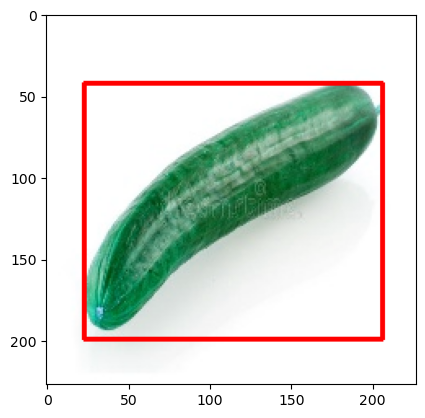

In [8]:
bnd_img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
plt.imshow(bnd_img)

In [9]:
def load_img(path) :
    X = []
    for i in sorted(glob.glob(path)) :
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        X.append(img)
    return np.asarray(X)

In [10]:
def load_xml(path) :
    y = []
    for i in sorted(glob.glob(path)) :
        c = 0
        obj = minidom.parse(i)
        folder = obj.getElementsByTagName('folder')[0].firstChild.nodeValue
        width = get_value(obj,'width')
        height = get_value(obj,'height')
        xmin = get_value(obj,'xmin')
        ymin = get_value(obj,'ymin')
        xmax = get_value(obj,'xmax')
        ymax = get_value(obj,'ymax')
        if "cucumber" in folder : 
            c = 1
        elif "eggplant" in folder :
            c = 2
        elif "mushroom" in folder :
            c = 3
        y.append([c,xmin,ymin,xmax,ymax])
    return np.asarray(y)

In [11]:
X = load_img('training_images/*.jpg')
X.shape

(186, 227, 227, 3)

In [12]:
Y = load_xml('training_images/*.xml')
Y.shape

(186, 5)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((148, 227, 227, 3), (148, 5), (38, 227, 227, 3), (38, 5))

In [14]:
y1_train = y_train[:,0:1]
y1_test = y_test[:,0:1]
y2_train = y_train[:,1:]
y2_test = y_test[:,1:]
y1_train.shape,y1_test.shape,y2_train.shape,y2_test.shape

((148, 1), (38, 1), (148, 4), (38, 4))

In [15]:
y1_train = tf.keras.utils.to_categorical(y1_train)
y1_test = tf.keras.utils.to_categorical(y1_test)

In [16]:
inp = tf.keras.layers.Input(shape=(227,227,3))
res = tf.keras.applications.ResNet152V2(include_top=False,weights="imagenet") (inp)
flatten = tf.keras.layers.Flatten() (res)
d1 = tf.keras.layers.Dense(128,activation='relu') (flatten)
d2 = tf.keras.layers.Dense(128,activation='relu') (d1)
out1 = tf.keras.layers.Dense(4,activation='softmax') (d2)
d3 = tf.keras.layers.Dense(256,activation='relu') (d2)
d4 = tf.keras.layers.Dense(256,activation='relu') (d3)
out2 = tf.keras.layers.Dense(4) (d4)

model = tf.keras.models.Model(inputs=inp,outputs=[out1,out2])
model.summary()

234545216/234545216 [==============================] - 304s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet152v2 (Functional)       (None, None, None,   58331648    ['input_1[0][0]']                
                                2048)                                                             
                                                                                                  
 flatten (Flatten)              (None, 131072)       0           ['resnet152v2[0][0]']            
                         

In [17]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
model.compile(optimizer='adam',loss=['categorical_crossentropy','huber'])

In [29]:
r = model.fit(X_train,[y1_train,y2_train],epochs=10)

Epoch 1/10
5/5 [==============================] - 173s 33s/step - loss: 35.3556 - dense_2_loss: 1.4969 - dense_5_loss: 33.8587
Epoch 2/10
5/5 [==============================] - 135s 26s/step - loss: 26.7811 - dense_2_loss: 0.6026 - dense_5_loss: 26.1785
Epoch 3/10
5/5 [==============================] - 152s 28s/step - loss: 25.5592 - dense_2_loss: 1.3412 - dense_5_loss: 24.2180
Epoch 4/10
5/5 [==============================] - 136s 26s/step - loss: 20.5706 - dense_2_loss: 1.0663 - dense_5_loss: 19.5043
Epoch 5/10
5/5 [==============================] - 137s 26s/step - loss: 21.0737 - dense_2_loss: 2.1095 - dense_5_loss: 18.9642
Epoch 6/10
5/5 [==============================] - 140s 27s/step - loss: 18.7063 - dense_2_loss: 1.5527 - dense_5_loss: 17.1536
Epoch 7/10
5/5 [==============================] - 144s 27s/step - loss: 17.4410 - dense_2_loss: 1.3354 - dense_5_loss: 16.1056
Epoch 8/10
5/5 [==============================] - 148s 28s/step - loss: 18.1117 - dense_2_loss: 0.6601 - dense_

In [30]:
model.evaluate(X_test,[y1_test,y2_test])

2/2 [==============================] - 4s 770ms/step - loss: 413301.6562 - dense_2_loss: 70154.2812 - dense_5_loss: 343147.3750


[413301.65625, 70154.28125, 343147.375]

In [31]:
pred_img = cv2.imread('training_images/mushroom_13.jpg')
c,bnd = model.predict(np.asarray([pred_img]))

1/1 [==============================] - 0s 299ms/step


In [32]:
bnd = np.round(bnd)
bnd = bnd.astype('int64')
bnd

array([[115378, 116334, 619099, 595598]], dtype=int64)

In [33]:
c = np.round(c)

In [34]:
def predict(img_path,model,url=False) :
    if url :
        pred_img = io.imread(img_path)
    else :
        pred_img = cv2.imread(img_path)
    pred_img = cv2.resize(pred_img,(227,227))
    c,bnd = model.predict(np.asarray([pred_img]))
    c = np.round(c)
    bnd = np.round(bnd)
    bnd = bnd.astype('int64')
    img = cv2.rectangle(pred_img,(bnd[0][0],bnd[0][1]),(bnd[0][2],bnd[0][3]),(255,0,0),1)
    fruit = ''
    if c[0][1] == 1 :
        fruit = 'Cucumber'
    elif c[0][2] == 1 :
        fruit = 'Egg Plant'
    elif c[0][3] == 1 :
        fruit = 'Mushroom'
    img = cv2.putText(img,fruit,(bnd[0][0],bnd[0][1]-3),cv2.FONT_HERSHEY_SIMPLEX,0.3,(0,255,0),1,255)
    plt.imshow(img)

1/1 [==============================] - 0s 345ms/step


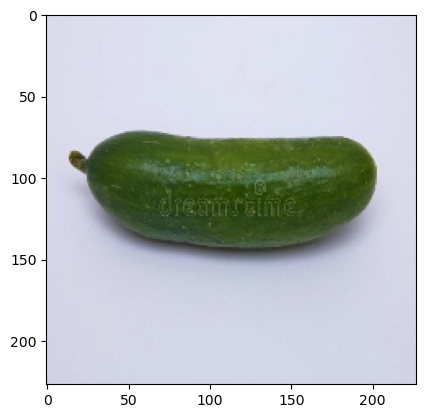

In [39]:
predict('training_images/cucumber_5.jpg',model,True)

In [36]:
# # save the model
#model.save('imglocalmodel.pk')

In [37]:
# # save the model
model.save('img_local_model.h5')